## Reconstructing the MMPI and the Adaptive Questionnaire

The MMPI2, as described in the main text, consists of 567 yes/no questions. Our dataset, which unfortunately for legal reasons cannot be distributed, contains the responses of 2428 individuals to the questionnaire. In this notebook we will process the questionnaire, reconstruct a probability field underlying the data, and then demonstrate the use of adaptive question trees to classify and predict the probability field of a new person using a small subset of the questions.

In [1]:
from imports import *
%run py_load_data.py de

We begin with the following dataset: $567 \times 2428$ yes/no answers (+1 and -1, with zeroes for questions that were not answered).

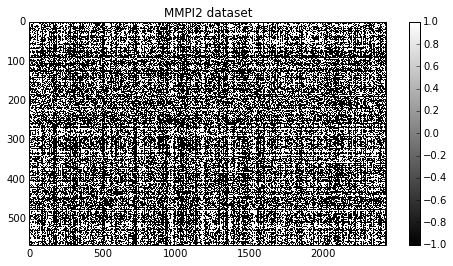

In [2]:
fig = plt.figure(figsize = (8,4))
bwplot2(data)
plt.colorbar()
plt.title("MMPI2 dataset")
plt.show()

### Organization

We begin by calculating affinities on the rows and columns, using cosine similarity. Then we calculate the diffusion maps, embed the data, and generate trees on the rows and columns. We then run the entire questionnaire process for two iterations, and look at the embeddings for each iteration:

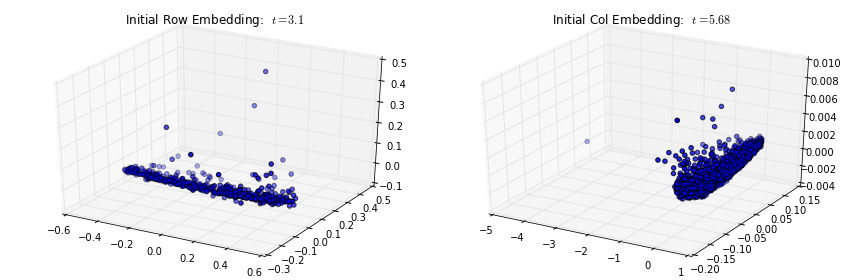

In [3]:
init_row_aff = affinity.mutual_cosine_similarity(data.T,threshold=0.0)
init_col_aff = affinity.mutual_cosine_similarity(data,threshold=0.0)
init_row_vecs,init_row_vals = markov.markov_eigs(init_row_aff,12)
init_col_vecs,init_col_vals = markov.markov_eigs(init_col_aff,12)
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121,projection="3d")
plot_embedding(init_row_vecs,init_row_vals,ax=ax,
               title="Initial Row Embedding: ")
ax2 = fig.add_subplot(122,projection="3d")
plot_embedding(init_col_vecs,init_col_vals,ax=ax2,
               title="Initial Col Embedding: ")
plt.tight_layout()
plt.show()

In [4]:
kwargs = {}
kwargs["threshold"] = 0.0
kwargs["row_alpha"] = 0.0
kwargs["col_alpha"] = 0.0
kwargs["row_beta"] = 1.0
kwargs["col_beta"] = 1.0
kwargs["tree_constant"] = 1.0
kwargs["n_iters"] = 2
params = questionnaire.PyQuestParams(questionnaire.INIT_AFF_COS_SIM,
                                     questionnaire.TREE_TYPE_FLEXIBLE,
                                     questionnaire.DUAL_EMD,
                                     questionnaire.DUAL_EMD,**kwargs)
qrun = questionnaire.pyquest(data,params)

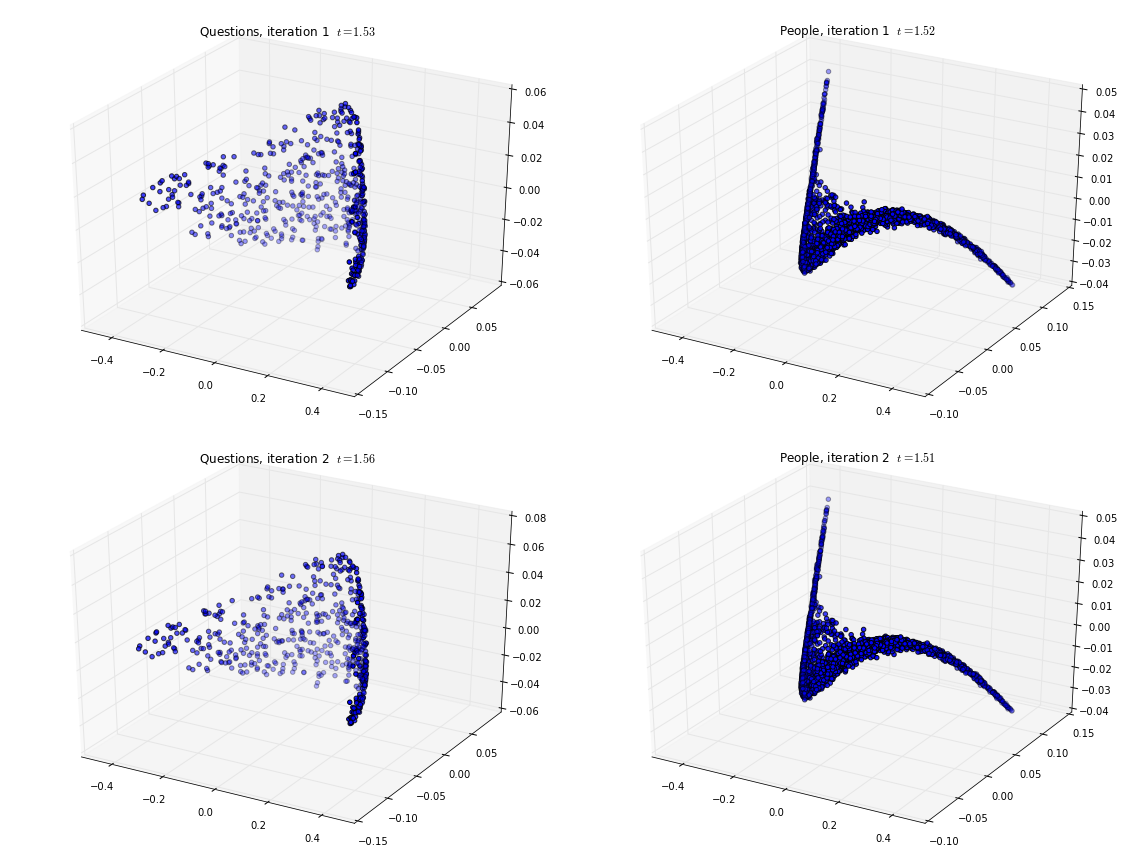

In [5]:
fig = plt.figure(figsize=(16,12))
m=len(qrun.col_trees)
axes = {}
for idx,col_tree in enumerate(qrun.col_trees):
    axes[2*idx+1] = fig.add_subplot(m,2,2*idx+1,projection="3d")
    row_emd = dual_affinity.calc_emd(data.T,col_tree,params.row_alpha,
                                     params.row_beta)
    row_aff = dual_affinity.emd_dual_aff(row_emd)
    row_vecs,row_vals = markov.markov_eigs(row_aff,4)
    plot_embedding(row_vecs,row_vals,ax=axes[2*idx+1],
                   title="Questions, iteration {} ".format(idx+1))
for idx,row_tree in enumerate(qrun.row_trees[1:]):
    axes[2*idx] = fig.add_subplot(m,2,2*idx+2,projection="3d")
    col_emd = dual_affinity.calc_emd(data,row_tree,params.col_alpha,
                                     params.col_beta)
    col_aff = dual_affinity.emd_dual_aff(col_emd)
    col_vecs,col_vals = markov.markov_eigs(col_aff,4)
    plot_embedding(col_vecs,col_vals,ax=axes[2*idx],
                   title="People, iteration {} ".format(idx+1))
plt.tight_layout()
plt.show()

So the iteration process converges pretty rapidly to a consistent set of embeddings. Notice that the people embedding takes an interesting form; that of a long curve that is stretched/elongated in a different direction toward the middle, but is pretty thin at either end.

We plot the final trees:

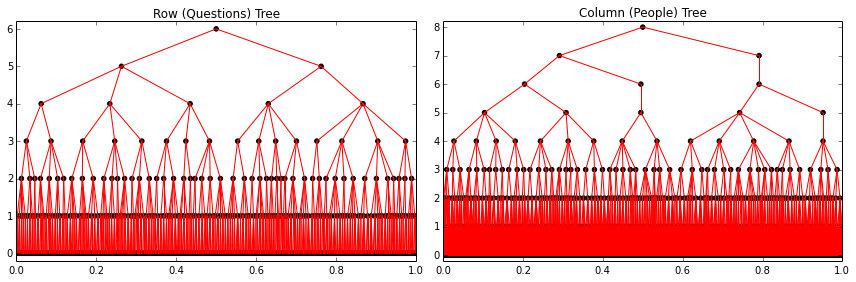

In [6]:
row_tree = qrun.row_trees[-1]
col_tree = qrun.col_trees[-1]
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plot_tree(row_tree,title="Row (Questions) Tree")
fig.add_subplot(122)
plot_tree(col_tree,title="Column (People) Tree")
plt.tight_layout()
plt.show()

We plot the original data set, organized by these trees:

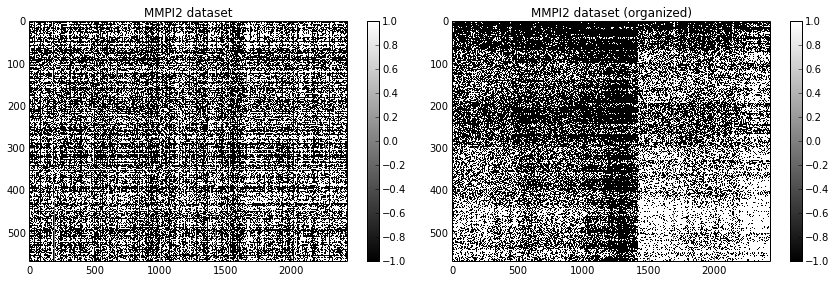

In [7]:
fig = plt.figure(figsize = (12,4))
fig.add_subplot(121)
bwplot2(data,colorbar=True,title="MMPI2 dataset")
fig.add_subplot(122)
bwplot2(barcode.organize_folders(row_tree,col_tree,data),
        colorbar=True,title="MMPI2 dataset (organized)")
plt.tight_layout()
plt.show()

We can see that the organization on the right exhibits quite a bit more structure than the raw data on the left. We consider the five groups at level 4 on the row tree. We paint the people embedding by the average response to each of those five groups (on a scale from red (yes) to blue (no)).

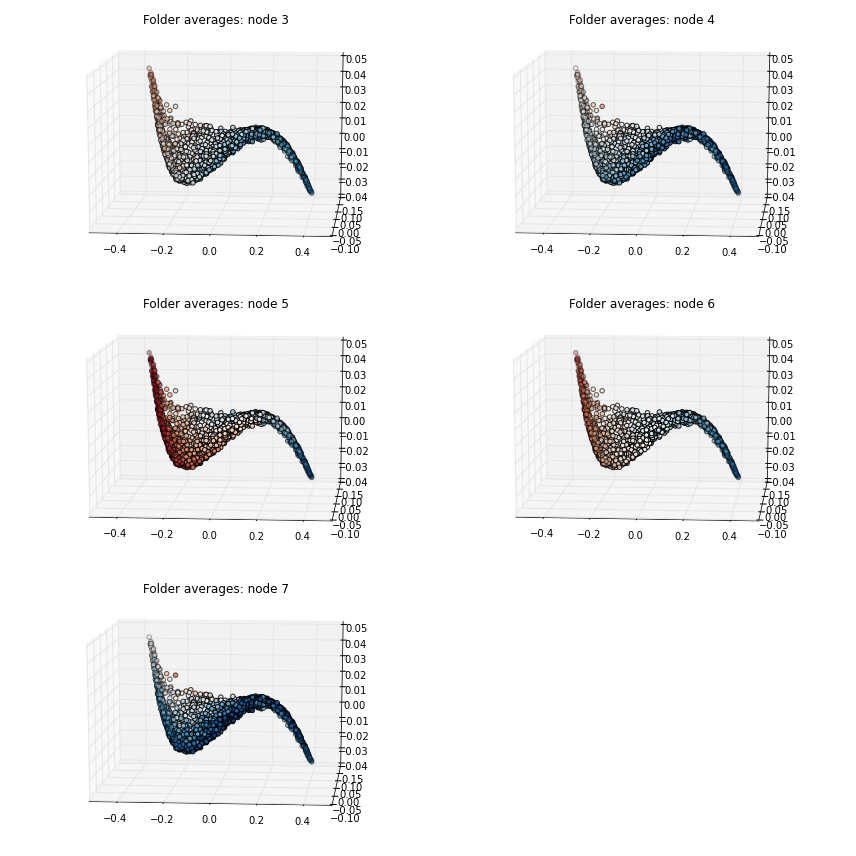

In [8]:
fig = plt.figure(figsize=(12,12))
avgs = tree_util.tree_averages(data,row_tree)
axes = {}
for idx,node in enumerate(sorted(row_tree.dfs_level(3),
                                 key=lambda x: x.idx)):
    axes[idx] = fig.add_subplot(3,2,idx+1,projection="3d")
    nodecolors = avgs[node.idx,:]
    plot_embedding(col_vecs,col_vals,nodecolors=nodecolors,
                   title="Folder averages: node {}".format(node.idx),
                   nodt=True,azim=-85,elev=12,ax=axes[idx])
plt.tight_layout()
plt.show()

The average response varies from question group to question group, but a clear pattern of decreasing "yes" answers can been seen from tail to tail.

We have an additional piece of external data, which are scores on each of nine different psychological disorders that the MMPI2 is designed to measure. We z-score the raw scores, and color the embedding by each of the scores in turn:

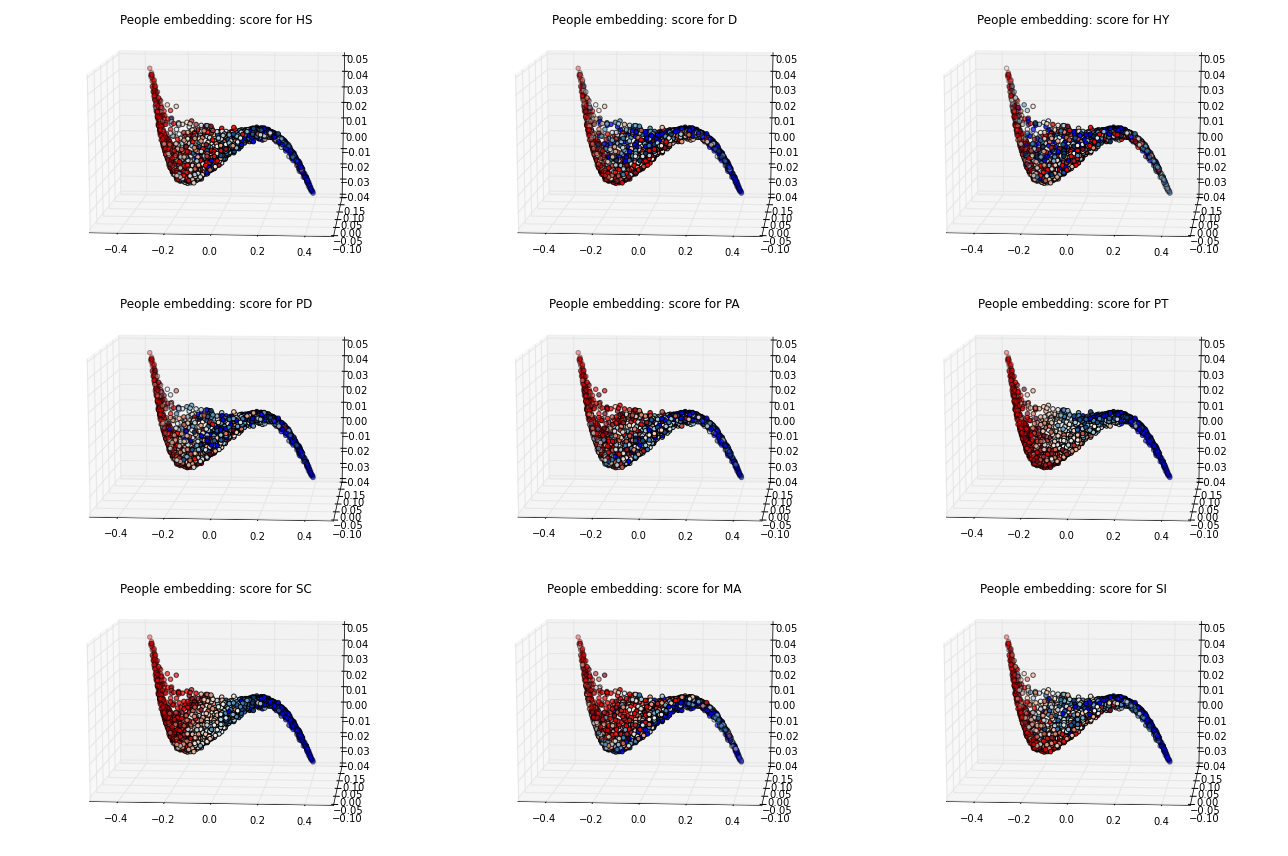

In [9]:
fig = plt.figure(figsize=(18,12))
avgs = tree_util.tree_averages(data,row_tree)
axes = {}
s=p_score_descs
for idx in xrange(9):
    axes[idx] = fig.add_subplot(3,3,idx+1,projection="3d")
    nodecolors = avgs[node.idx,:]
    plot_embedding(col_vecs,col_vals,nodecolors=p_scores[idx,:],
                   title="People embedding: score for {}".format(s[idx]),
                   nodt=True,azim=-85,elev=12,ax=axes[idx])
plt.tight_layout()
plt.show()

While the embedding does not neatly divide the disorder scores into bands, there is still a clear pattern of high scores on one tail of the embedding and low scores on the other, with varying degrees of mixture in the larger ball in the center. As one final example that the organization we obtain from the questionnaire process is at least reasonable, we consider two groups of questions that are grouped together as folders in the row tree.

In [10]:
group1 = [x.elements for x in 
          row_tree.dfs_level(row_tree.tree_depth-1) if 23 in x.elements]
for x in [q_descs[y] for y in group1]:
    print "\n".join(x)
print "****"
group2 = [x.elements for x in 
          row_tree.dfs_level(row_tree.tree_depth-2) if 36 in x.elements]
for x in [q_descs[y] for y in group2]:
    print "\n".join(x)

24. Evil spirits possess me at times.
72. My soul sometimes leaves my body.
96. I see things or animals or people around me that others do not see.
228. There are persons who are trying to steal my thoughts and ideas.
468. I am afraid of being alone in a wide-open place.
****
32. I have had very peculiar and strange experiences.
37. At times I feel like smashing things.
309. I usually have to stop and think before I act even in small matters.
517. I find it difficult to hold down a job.
562. It is hard for me to accept compliments.


By inspection, it certainly seems that these questions are quite reasonably clustered together: the first group of questions seems to broadly relate to the perception of supernatural events, while the second group seems to relate to difficulties with self-awareness.

### Reconstruction

Next we will try to reconstruct the underlying probability field that gave rise to the MMPI2 dataset. We begin by considering two main methods: the wavelet shrinkage reconstruction based on SURE, and the reconstruction based on truncation of coefficients corresponding to folders of less than a certain size.

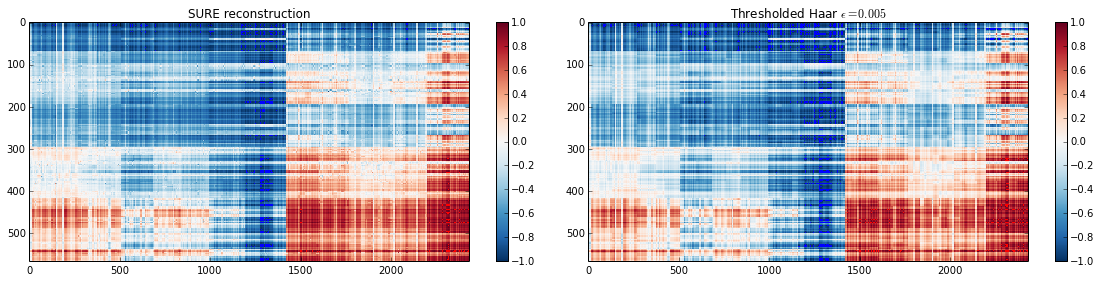

In [11]:
sure_recon = tree_recon.recon_2d_sure(data,row_tree,col_tree)
recon = tree_recon.recon_2d_haar_folder_size(data,row_tree,col_tree,0.005)
fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
cplot(barcode.organize_folders(row_tree,col_tree,sure_recon),
      colorbar=True,title="SURE reconstruction")
fig.add_subplot(122)
cplot(barcode.organize_folders(row_tree,col_tree,recon),
      colorbar=True,title="Thresholded Haar $\epsilon = 0.005$")
plt.tight_layout()
plt.show()

Next we spin cycle. We will generate sets of trees, using different methods. We will generate flexible trees using eight different tree constants. We will also generate randomized binary trees, using four different balance constants, sampling each twice. In all this will constitute 16 sets of trees. Then we will cross-match these trees to produce 256 pairs of trees, and reconstruct using each method, taking the average over all 256 tree-pairs as the probability field.

In [12]:
np.random.seed(20140401)
tree_constants = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.5]
balance_constants = [1.1,1.5,2.0,2.5]
params_list = []
for tree_constant in tree_constants:
    kwargs = {}
    kwargs["n_iters"] = 2
    kwargs["threshold"] = 0.0
    kwargs["row_alpha"] = 0.0
    kwargs["col_alpha"] = 0.0
    kwargs["row_beta"] = 1.0
    kwargs["col_beta"] = 1.0
    kwargs["tree_constant"] = tree_constant
    params = questionnaire.PyQuestParams(questionnaire.INIT_AFF_COS_SIM,
                                         questionnaire.TREE_TYPE_FLEXIBLE,
                                         questionnaire.DUAL_EMD,
                                         questionnaire.DUAL_EMD,**kwargs)
    params_list.append(params)

for balance_constant in balance_constants:
    kwargs["bal_constant"] = balance_constant
    params = questionnaire.PyQuestParams(questionnaire.INIT_AFF_COS_SIM,
                                         questionnaire.TREE_TYPE_BINARY,
                                         questionnaire.DUAL_EMD,
                                         questionnaire.DUAL_EMD,**kwargs)
    params_list.append(params)
    params_list.append(params)
qruns = []
for params in params_list:
    qruns.append(questionnaire.pyquest(data,params))

In [13]:
total_sure_recon = np.zeros(data.shape)
total_haar_recon = np.zeros(data.shape)
for qrun in qruns:
    for qrun2 in qruns:
        row_tree = qrun.row_trees[-1]
        col_tree = qrun2.col_trees[-1]
        sure_recon = tree_recon.recon_2d_sure(data,row_tree,col_tree)
        tree_recon.threshold_recon(sure_recon,-1.0,1.0)
        total_sure_recon += sure_recon
        haar_recon = tree_recon.recon_2d_haar_folder_size(
                            data,row_tree,col_tree,0.005)
        tree_recon.threshold_recon(haar_recon,-1.0,1.0)
        total_haar_recon += haar_recon
total_sure_recon /= 1.0*(len(qruns)**2)
total_haar_recon /= 1.0*(len(qruns)**2)
total_recon = (total_sure_recon + total_haar_recon)/2.0

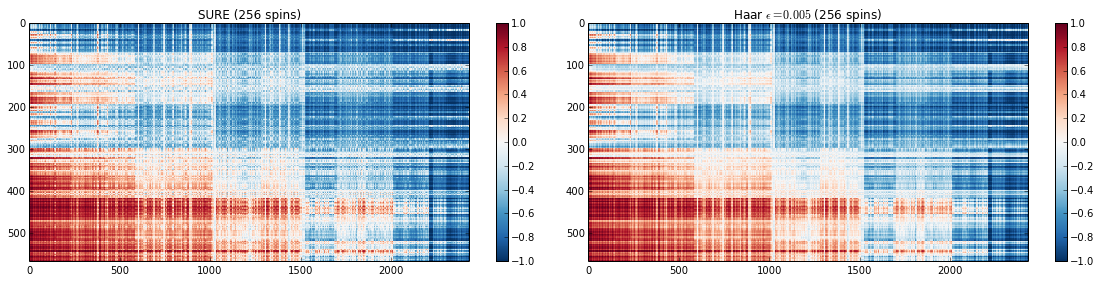

In [14]:
row_tree = qruns[4].row_trees[-1]
col_tree = qruns[4].col_trees[-1]
fig = plt.figure(figsize=(16,4))
fig.add_subplot(121)
cplot(barcode.organize_folders(row_tree,col_tree,total_sure_recon),
      colorbar=True,title="SURE ({} spins)".format(len(qruns)**2))
fig.add_subplot(122)
cplot(barcode.organize_folders(row_tree,col_tree,total_haar_recon),
      colorbar=True,
      title="Haar $\epsilon = 0.005$ ({} spins)".format(len(qruns)**2))
plt.tight_layout()
plt.show()

Because the suborganizations of the trees are somewhat arbitrary, we permute the rows and columns to coincide with the empirical mean response by each person and on each question:

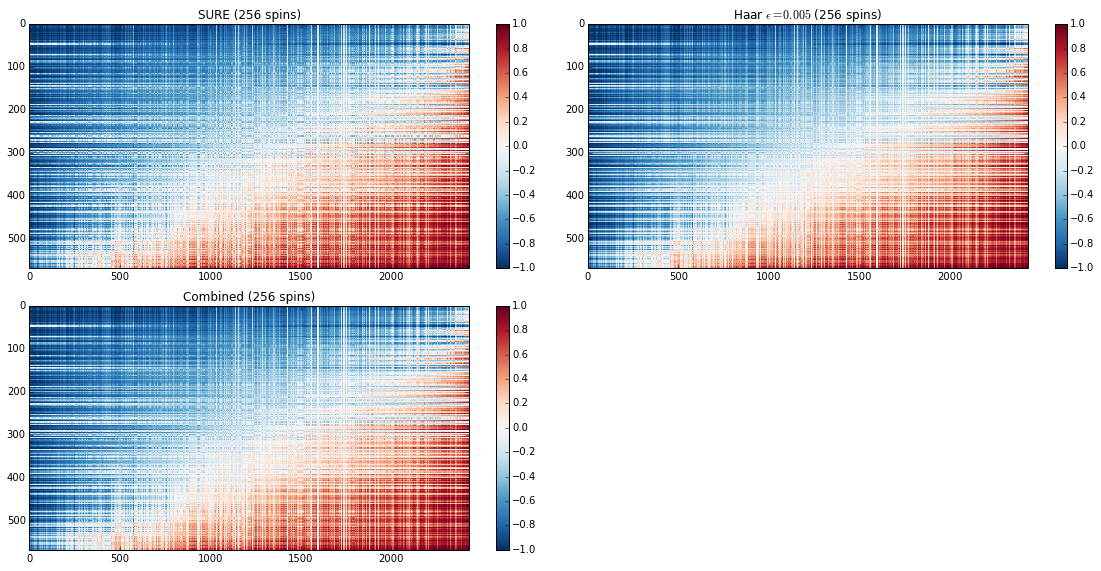

In [15]:
row_order = np.sum(data,axis=1).argsort()
col_order = np.sum(data,axis=0).argsort()

fig = plt.figure(figsize=(16,8))
fig.add_subplot(221)
cplot(total_sure_recon[row_order,:][:,col_order],colorbar=True,
      title="SURE ({} spins)".format(len(qruns)**2))
fig.add_subplot(222)
cplot(total_haar_recon[row_order,:][:,col_order],colorbar=True,
      title="Haar $\epsilon = 0.005$ ({} spins)".format(len(qruns)**2))
fig.add_subplot(223)
cplot(total_recon[row_order,:][:,col_order],colorbar=True,
      title="Combined ({} spins)".format(len(qruns)**2))
plt.tight_layout()
plt.show()

### The Adaptive Questionnaire

Next we turn to the following problem. Suppose we have a training set of data, and the model assumptions of a smooth probability field are assumed to hold. Then we want to take a new person who has not answered any of the questions, and predict her probability field by asking an adaptively chosen small subset of the questions. The first step is to define a training set.

In [16]:
indices = np.random.rand(data.shape[1]).argsort()
train_data = data[:,indices[0:2000]]
test_data = data[:,indices[2000:]]

First we calculate the probability field for the training set, using the same methodology as above. Here we combine the two methods (SURE and Haar truncation) to provide even more artifact smoothing.

In [17]:
train_qruns = []
for params in params_list:
    train_qruns.append(questionnaire.pyquest(train_data,params))

In [18]:
train_recon = np.zeros(train_data.shape)
for qrun in train_qruns:
    for qrun2 in train_qruns:
        row_tree = qrun.row_trees[-1]
        col_tree = qrun2.col_trees[-1]
        sure_recon = tree_recon.recon_2d_sure(
                        train_data,row_tree,col_tree)
        tree_recon.threshold_recon(sure_recon,-1.0,1.0)
        train_recon += sure_recon
        haar_recon = tree_recon.recon_2d_haar_folder_size(
                        train_data,row_tree,col_tree,0.005)
        tree_recon.threshold_recon(haar_recon,-1.0,1.0)
        train_recon += haar_recon
train_recon /= 2.0*(len(qruns)**2)

Next we build a **question tree** on the people, by analyzing the training set. The method by which this is computed is fully described in the main text, but the main idea is this. At each node, starting with the root, we calculate the diffusion on a graph built on the people at that node. We take the first non-trivial eigenvector of that node and then we use the LASSO method to identify a small subset of questions we can ask in order to linearly predict the eigenvector coordinates for each column. Then we take the original data, predict the eigenvector coordinates, and split the node into two children based on the sign of the predicted eigenvector coordinates.

In [19]:
import question_tree
row_tree = qruns[4].row_trees[-1]
col_tree = qruns[4].col_trees[-1]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    q_tree = question_tree.mtree(train_data,row_tree)

Here is the question tree.

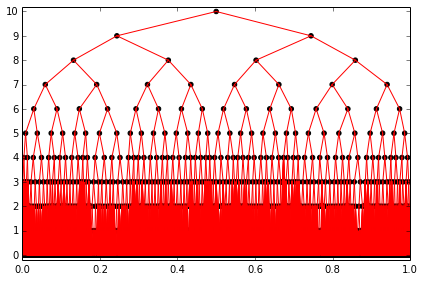

In [20]:
plot_tree(q_tree)
plt.tight_layout()
plt.show()

Now we take the test set. We pretend that we do not have any answers from these people. Then we locate them within the tree by asking them the appropriate questions at each node, calculating the predicted value of the linear model at that node, and then proceeding down the indicated branch of the tree. When we reach a small folder near the bottom of the tree, we take their predicted probability field values to be the mean of the folder in which they have been located.

In [21]:
total_recon = (total_sure_recon + total_haar_recon)/2.0
pred_data = np.zeros(test_data.shape)
folders = np.zeros(test_data.shape[1],np.int)
for cidx,colidx in enumerate(indices[2000:]):
    v = data[:,colidx]
    cur_node = q_tree
    while hasattr(cur_node,"lm"):
        peig = cur_node.lm.predict(v[cur_node.active])
        if peig > 0.0:
            cur_node = cur_node.children[1]
        else:
            cur_node = cur_node.children[0]
    pred_data[:,cidx] = np.mean(train_recon[:,cur_node.elements],axis=1)
    folders[cidx] = cur_node.idx

Now we can compare these predicted probability field values to the fields calculated in the probability field for the entire dataset. Taking the absolute $l_1$ error in the probabilities, we find that our method, which asks only at most 50 (and usually fewer) questions, can reconstruct the probability field for an unknown person with an average error per question of only 0.063.  Note that this is not like a classifier or a standard statistical prediction task, where we are trying to use a set of independent data to predict a single value or a single class membership. Instead, we are asking less than 10% of the questions on the questionnaire, and inferring the probability field underlying the answers to the other 90+% of the questions all at once.

In [22]:
diffs = pred_data - total_recon[:,indices[2000:]]
print "{:3.2%}".format(np.mean(np.abs(diffs))/2.0)

6.32%
